In [ ]:
title: "NYCTaxi"
author: "민경은"
format: dashboard
execute: 
  enabled: true
  cache: false
  freeze: false

In [16]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import json
import requests
import pickle

In [17]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

In [19]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv").assign(
    log_trip_duration = lambda df: np.log(df.trip_duration),
    pickup_datetime = lambda df: df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = lambda df: df.dropoff_datetime.apply(pd.to_datetime),
    dist = lambda df: np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = lambda df: df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)
df_small = df[::100].reset_index(drop=True)
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,dist,speed,pickup_hour,dropoff_hour,dayofweek
0,id2875421,B,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,0.017680,0.000039,17,17,0
1,id3194108,A,2016-06-01 11:48:41,2016-06-01 12:19:07,1,-74.005028,40.746452,-73.972008,40.745781,N,1826,7.509883,0.033027,0.000018,11,12,2
2,id3564028,A,2016-01-02 01:16:42,2016-01-02 01:19:56,1,-73.954132,40.774784,-73.947418,40.779633,N,194,5.267858,0.008282,0.000043,1,1,5
3,id1660823,B,2016-03-01 06:40:18,2016-03-01 07:01:37,5,-73.982140,40.775326,-74.009850,40.721699,N,1279,7.153834,0.060363,0.000047,6,7,1
4,id1575277,B,2016-06-11 16:59:15,2016-06-11 17:33:27,1,-73.999229,40.722881,-73.982880,40.778297,N,2052,7.626570,0.057778,0.000028,16,17,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14582,id3647353,A,2016-05-16 22:12:09,2016-05-16 22:27:46,1,-73.990219,40.737076,-73.986748,40.702194,N,937,6.842683,0.035054,0.000037,22,22,0
14583,id2064944,A,2016-05-23 08:04:35,2016-05-23 08:19:20,1,-73.987068,40.730728,-73.974983,40.751331,N,885,6.785588,0.023886,0.000027,8,8,0
14584,id3286731,B,2016-05-31 16:56:13,2016-05-31 17:38:44,1,-73.863541,40.769711,-73.994644,40.750435,N,2551,7.844241,0.132513,0.000052,16,17,1
14585,id3453691,B,2016-03-07 18:11:54,2016-03-07 18:29:09,1,-74.006531,40.738232,-73.985970,40.726978,N,1035,6.942157,0.023439,0.000023,18,18,0


In [21]:
#(1) 요일, 시간에 따른 평균속력 시각화
day_map = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
# 시간대별 평균 속력 계산
average_speed_by_hour = df.groupby('pickup_hour')['speed'].mean()
# 시간대를 0~23에서 월, 화, 수 등의 문자로 변환
df['day'] = df['dayofweek'].map(day_map)
# 요일과 시간대별 평균 속력 계산
average_speed_by_day_hour = df.groupby(['day', 'pickup_hour'])['speed'].mean().reset_index()

In [22]:
#(2) 요일, 시간에 따른 평균 이동거리 시각화
# 요일, 시간대별 평균 이동거리 계산
average_distance_by_day_hour = df.groupby(['day', 'pickup_hour'])['dist'].mean().reset_index()

In [23]:
#1-(1) 요일, 시간에 따른 평균속력 시각화
fig1 = px.line(average_speed_by_day_hour, x='pickup_hour', y='speed', color='day',
              labels={'pickup_hour': '시간', 'speed': '평균 속력', 'day': '요일'},
              title='요일 및 시간대별 평균 속력')

In [24]:
#1-(2) 요일,시간에 따른 평균이동거리 시각화   
fig2 = px.line(average_distance_by_day_hour, x='pickup_hour', y='dist', color='day',
              labels={'pickup_hour': '시간', 'dist': '평균 이동거리', 'day': '요일'},
              title='요일 및 시간대별 평균 이동거리')

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



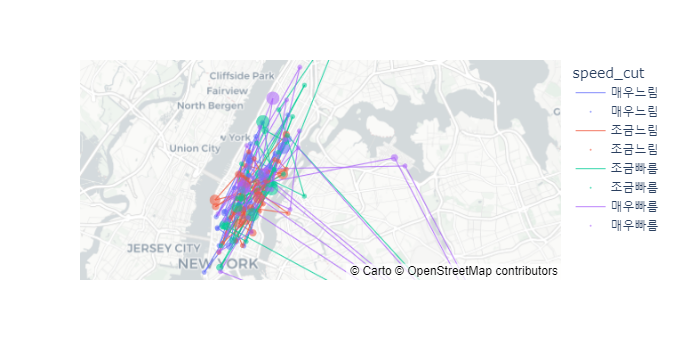

In [26]:
#1-(3) 속력별 경로 시각화
fig= df_small.assign(
    speed_cut = pd.qcut(df_small.speed, 4, labels=['매우느림','조금느림','조금빠름','매우빠름'])
).sort_values('speed_cut')

fig3 = px.line_mapbox(
    data_frame=fig,
    lat='pickup_latitude',
    lon='pickup_longitude',
    color='speed_cut',
    center={'lat': 40.7322, 'lon': -73.9052},
    mapbox_style='carto-positron',
    zoom=11,
)

scatter_data = px.scatter_mapbox(
    data_frame=fig,
    lat='pickup_latitude',
    lon='pickup_longitude',
    size='passenger_count',
    size_max=10,
    color='speed_cut',
    mapbox_style='carto-positron',
    zoom=11,
).data

for sd in scatter_data:
    fig3.add_trace(sd)

fig3.update_traces(
    line={'width': 1},
    opacity=0.8
)

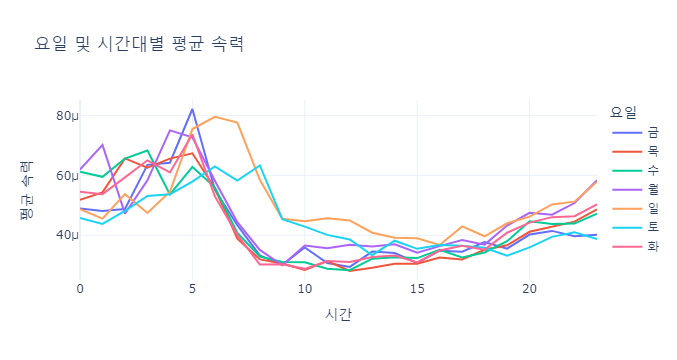

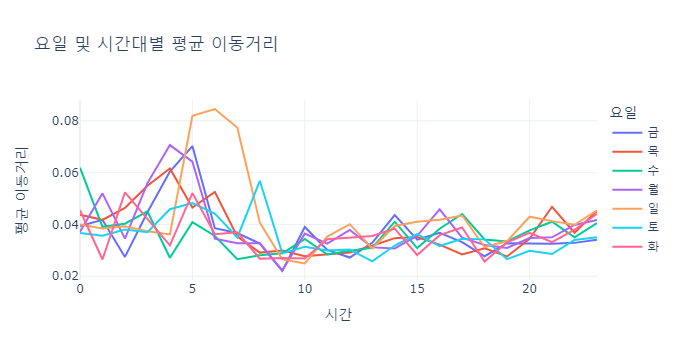

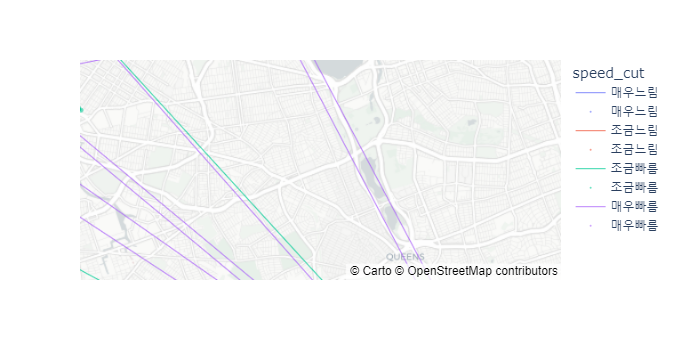

In [27]:
# 기말고사1-(1),(2)

#| title: 요일,시간에 따른 평균속력 시각화        
fig1.show()


#| title: 요일,시간에 따른 평균이동거리 시각화        
fig2.show()

# 기말고사1-(3)
#| title: 속력별 경로 시각화
fig3.show(config={'scrollZoom': False})